# RPG: Robot Proving Grounds
# Mapping

Robotic mapping is a process where a robot utilizes onboard sensors (e.g. lidar, camera) to collect data to generate a map or a floor plan of its surrounding environment via certain algorithms. By doing this, it would be able to localize itself and perform other particular tasks. In this page, we will take a look at a classic mapping algorithm called Occupancy Grid Mapping (OGM) and its application in a simple setting. Let's go!

Reference: Sebastian Thrun, Wolfram Burgard, and Dieter Fox. *Probabilistic Robotics*, Ch.9, pages 221 - 244.

(Contributor(s): Jeffrey Chen, 02/2024)

# Occupancy Grid Mapping (OGM)

Occupancy Grid Mapping considers a probabilistic representation of the environment of interest. The field is evenly partitioned into a certain number of cells, and each cell indicates its occupancy status by 1 (occupied) and 0 (free).

**Key assumptions:**
- Robot poses (states) are known.
- Occupancy of individual cells is independent.
- Each cell is a binary random variable: it is either completely free or occupied.
- The environment is static (i.e. the occupancy status doesn't change over time).

**Sensor:**

As the robot moves around, its onboard LiDAR would emit multiple ray beams along different directions to scan the surrounding environment. The sensor records the reflection time of each ray, which would be used to determine whether there is any obstacle existing along that direction.


![](https://drive.google.com/uc?export=view&id=1Dysu6Te3AqbAChNjI8-khW6UPI9qQ_gz)

Given the robot poses and sensor measurement data, OGM approximates the posterior probabilities of occupancy for all scanned cells:

> $p(m | z_{1:t}, x_{1:t})$, where m: status of grid cells, z: measurement, x: robot state,

eventually obtaining a complete grid map of the environment.


---
**Algorithm:** Occupancy Grid Mapping (OGM)


**Data:**
1. log-odds values for all cells, {$l_{t-1}$};
2. robot pose, $x_t$;
3. sensor measurements, $z_t$.

**Steps:**

    for all cells m_i do
        if m_i in the ray cone of z_t then
            l_t_i = l_(t-1)_i + inverse_sensor_model(m_i, x_t, z_t) - prior_log-odd_value
        else
            l_t_i = l_(t-1)_i
        endif
    endfor
    return {l_t}

**Return:**
* The latest log-odds values for all cells, {$l_t$};

---



**-->> First, let's install some necessary packages:**

We are going to use the physics engine **PyBullet**, which establishes an ideal simulated environment for our demonstration.

**[This step may take some time]**

In [ ]:
!pip install gitpython
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 2.4 MB/s eta 0:00:00


In [ ]:
import git
!cd /
!rm -rf /content/OGM4Colab/
!git clone https://github.com/jypipi/OGM4Colab.git

Cloning into 'OGM4Colab'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 491 (delta 22), reused 39 (delta 13), pack-reused 440
Receiving objects: 100% (491/491), 10.12 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (220/220), done.


**Classes of Interest in the OGM Implementation:**

*Simulation*

* Initialize the environment, robot, and path simulation in PyBullet.
* Environment: a 5x5 square field with boundary walls and 4 square obstacles.
* Robot: 4-wheel car with Ackermann steering geometry.
* Sensor: LiDAR (Ray length: 2.0, ray count: 50, ray cone angle: 90 deg).
* Robot state: x, y, theta (raw angle).

*PathSimulator*

* Control the robot to move along a given path.
* Path: 14 waypoints (including the start point).
* Control: a PD controller.

*OGM*

* Implement OGM algorithm, Bresenham's line algorithm, inverse sensor model, etc.
* Provide visualization.
* Output a probabilistic grid map.

**Techniques in OGM:**

**1. Log-odds Representation**

* $l_{t,i}$ = $\log \cfrac{p(m_i | z_{1:t}, x_{1:t})}{1 - p(m_i | z_{1:t}, x_{1:t})}$

* The advantage of using log-odds representation of occupancy is that we can avoid numerical instabilities for probabilities near zero or one, and it is easy to convert back to a probability ranging from 0 to 1.

**2. Bresenham's Line Algorithm**

* This auxiliary algorithm determines all the grids that a given line passes through. In OGM, it calculates all the cells within the detection range of each ray.

**3. Inverse Sensor Model**

Inverse sensor model is leveraged to update the log-odd value ($l_{t,i}$) for each cell i, given current robot pose and the latest sensor measurement.


    if this cell is not in the current ray cone then
        return prior_log-odd_value (l_0)
    if the distance to this cell is close to the maximum range while still in the ray cone then
        return occupancy log-odd value (l_occ)
    if this cell is within the ray cone and the distance to it is less than the maximum range then
        return unoccupancy log-odd value (l_free)


**Here is a portion of the implementation of the probabilistic OGM algorithm:**

```
def mapping(self, dataset):
    """
    Main function to operate occupancy grid mapping. It updates the log odd
        scores and occupancy probabilities for the percepted grids.

    Parameters:
        dataset (tuple): Robot's current pose and the array of the end
            points for all laser rays.
    Returns:
        None
    """

    pose, hitPoints = dataset[0], dataset[1]
    rayConeGrids_World, Zt, measPhi, rayConeEnds_World = self.perceptedCells(pose, hitPoints)
    self.plotMap = deepcopy(self.probGridMap)
    self.rayConeEnds_Grid = \
        [World2Grid(i, self.realMapSize, self.gridMapSize, self.res) for i in rayConeEnds_World]

    # Update the log odds for all cells with the perceptual field of lidar
    for grid in rayConeGrids_World:
        grid_coord = World2Grid(grid, self.realMapSize, self.gridMapSize, self.res)
        i, j = grid_coord[1], grid_coord[0]

        self.log_t[i][j] += self.inv_sensor_model(pose, grid, Zt, self.sim.Z_max, measPhi) \
                          - self.log_prior
        
        # Convert to the occupancy probability
        P_mi = 1 - 1/(1+np.exp(self.log_t[i][j]))

        # Update the probabilistic grid map based on the latest log odds
        # 1) When the grid is likely to be occupied
        if (P_mi > 0.5):
            self.probGridMap[i][j] = 0 # set to zero to plot in black
        # 2) When the grid's status is likely undetermined
        elif (P_mi == 0.5):
            self.probGridMap[i][j] = 0.5 # set to 0.5 to plot in grey
        # 3) When the grid is likely to be free
        else:
            self.probGridMap[i][j] = 1 # set to one to plot in white
```


```
def inv_sensor_model(self, xt, grid_mi, Zt, Z_max, measPhi):
    """
    The function to implement the inverse sensor model to update
        the log odd score for each grid.

    Parameters:
        xt (array): Robot pose [x, y, theta].
        grid_mi (tuple): World coordinate of grid center.
        Zt (numpy 2D array): Array of range measurements for all rays.
        Z_max (float): Maximum measurement range of lidar.
        measPhi (numpy 2D array): Array of relative angles between robot
            and Lidar rays.
    Returns:
        float: Log odd score update.
    """

    # Distance between robot and grid center
    r = np.sqrt((grid_mi[0]-xt[0])**2 + (grid_mi[1]-xt[1])**2)
    # Relative angle between robot and grid center
    phi = np.arctan2(grid_mi[1]-xt[1], grid_mi[0]-xt[0]) - xt[2]
    # Index of the ray that corresponds to this measurement
    k = np.argmin(abs(np.subtract(phi, measPhi)))

    # Determine the update of log odd score for this grid
    if ((r > np.minimum(Z_max, Zt[k]+self.res/2.0)) or (np.abs(phi-measPhi[k]) > self.sim.beta/2.0)):
        return self.log_prior
    elif ((Zt[k] < Z_max) and (np.abs(r-Zt[k]) < self.res/2.0*np.sqrt(2))):
        return self.l_occ
    elif (r < Zt[k]):
        return self.l_free
    else:
        return 0.0
```

Let's get started to visualize the output -->

**[This step may take more time...first, make your choices. Run it!~]**

Total run time: 3 min 29.4 sec.


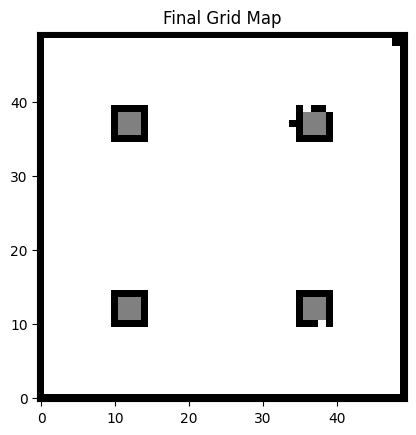

<Figure size 640x480 with 0 Axes>

In [ ]:
%run /content/OGM4Colab/OGM_Colab/OGM.py

##**Results & Discussion:**

After a glimpse of Occupancy Grid Mapping, can you tell some advantages and limitations of this algorithm?

![](https://drive.google.com/uc?export=view&id=14AaYAZOOZsiAh9LJYzh7vLcIU0vT18y_)

![](https://drive.google.com/uc?export=view&id=1k-JbFlB59bIGwAa6XHG2RWULdgVvjr1X)
